# 6. Knn prediction of used car prices refined

## Context

I have written a from scratch algorithm for k nearest neighbors (knn) classification and tested it out on the Iris and Usedcar datasets. I added module code to help me quickly normalize and standardize numerical features in the raw dataset. Here I will further refine the approach of applying a k nearest neighbor regression to predict prices by using a validation test set and distance weights to see if I can further reduce the error in my predictions.

## Work outline

I will be updating module code to include new functions from the notebook #4 and adding extension functions to enable predicting a continuous variable. The [used car dataset](https://www.engineeringbigdata.com/wp-content/uploads/usedcars.csv) is from `www.engineeringbigdata.com`.

### Steps

1. import module from local filepath; load local data file
2. plot the previously pivoted data to visualize distributions and correlations
3. split the dataset into training, validation, and test populations
4. choose parameters to reduce and run predict_category_from_knn on validation set to minimize errors
5. find score for algorithms


## Result

TBD

## Next steps

Next I will consider how to scale and adjust weights to improve the model predictiveness.


## 1. import module from local filepath; load local data file

Also inspect the dataset to assess which are numerical features and which are categorical features


In [2]:
from collections import Counter
from math import fsum

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from knn_base import euclidean_distance
from knn_base import find_k_neighbors
from dataset_prep import raw_dataset_csv_to_nested_list
from dataset_prep import inspect_types_in_dataset
from dataset_prep import cast_numbers_to_float
from dataset_prep import split_dataset
from dataset_prep import norm_dataset
from dataset_prep import standardize_dataset
from knn_regression import predict_from_knn_average
from knn_regression import predict_from_knn_linear_distance_weighted
from knn_regression import predict_from_knn_gaussian_distance_weighted
from knn_regression import predict_knn_regression_for_set

In [3]:
# load raw dataset
raw_dataset = raw_dataset_csv_to_nested_list('data/usedcars.csv')

In [4]:
raw_pivoted_dataset = raw_dataset_csv_to_nested_list('data/pivoted_usedcars.csv')

In [5]:
raw_dataset[:5]

[['year', 'model', 'price', 'mileage', 'color', 'transmission'],
 ['2011', 'SEL', '21992', '7413', 'Yellow', 'AUTO'],
 ['2011', 'SEL', '20995', '10926', 'Gray', 'AUTO'],
 ['2011', 'SEL', '19995', '7351', 'Silver', 'AUTO'],
 ['2011', 'SEL', '17809', '11613', 'Gray', 'AUTO']]

In [6]:
raw_dataset_array = np.array(raw_dataset)

In [7]:
raw_dataset_array.shape

(151, 6)

In [8]:
raw_pivoted_dataset_array = np.array(raw_pivoted_dataset)

In [9]:
raw_pivoted_dataset_array.shape

(151, 17)

In [10]:
float_casted_list_dataset = cast_numbers_to_float(raw_pivoted_dataset)

In [11]:
for i in range(raw_pivoted_dataset_array.shape[1]):
    print inspect_types_in_dataset(float_casted_list_dataset, i)

Counter({<type 'float'>: 150, <type 'str'>: 1})
Counter({<type 'float'>: 150, <type 'str'>: 1})
Counter({<type 'float'>: 150, <type 'str'>: 1})
Counter({<type 'float'>: 150, <type 'str'>: 1})
Counter({<type 'float'>: 150, <type 'str'>: 1})
Counter({<type 'float'>: 150, <type 'str'>: 1})
Counter({<type 'float'>: 150, <type 'str'>: 1})
Counter({<type 'float'>: 150, <type 'str'>: 1})
Counter({<type 'float'>: 150, <type 'str'>: 1})
Counter({<type 'float'>: 150, <type 'str'>: 1})
Counter({<type 'float'>: 150, <type 'str'>: 1})
Counter({<type 'float'>: 150, <type 'str'>: 1})
Counter({<type 'float'>: 150, <type 'str'>: 1})
Counter({<type 'float'>: 150, <type 'str'>: 1})
Counter({<type 'float'>: 150, <type 'str'>: 1})
Counter({<type 'float'>: 150, <type 'str'>: 1})
Counter({<type 'float'>: 150, <type 'str'>: 1})


In [12]:
no_scale_pivoted_dataset_array = raw_pivoted_dataset_array[1:].astype(np.float)

In [13]:
no_scale_pivoted_dataset_array[:3]

array([[2.0110e+03, 7.4130e+03, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 2.1992e+04],
       [2.0110e+03, 1.0926e+04, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.0995e+04],
       [2.0110e+03, 7.3510e+03, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.9995e+04]])

In [14]:
raw_pivoted_dataset_array[:3]

array([['year', 'model', 'AUTO', 'MANUAL', 'SE', 'SES', 'SEL', 'Black',
        'Silver', 'Red', 'Blue', 'Gray', 'White', 'Green', 'Yellow',
        'Gold', 'price'],
       ['2011.0', '7413.0', '1.0', '0.0', '0.0', '0.0', '1.0', '0.0',
        '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '1.0', '0.0',
        '21992.0'],
       ['2011.0', '10926.0', '1.0', '0.0', '0.0', '0.0', '1.0', '0.0',
        '0.0', '0.0', '0.0', '1.0', '0.0', '0.0', '0.0', '0.0',
        '20995.0']], dtype='|S8')

## 2. plot the previously pivoted data to visualize distributions and correlations

Also re-construct, normalized, standardized, and re-assembled the datasets to prepare for applying prediction functions


In [16]:
import pandas as pd

In [17]:
df = pd.read_csv('data/pivoted_usedcars.csv')

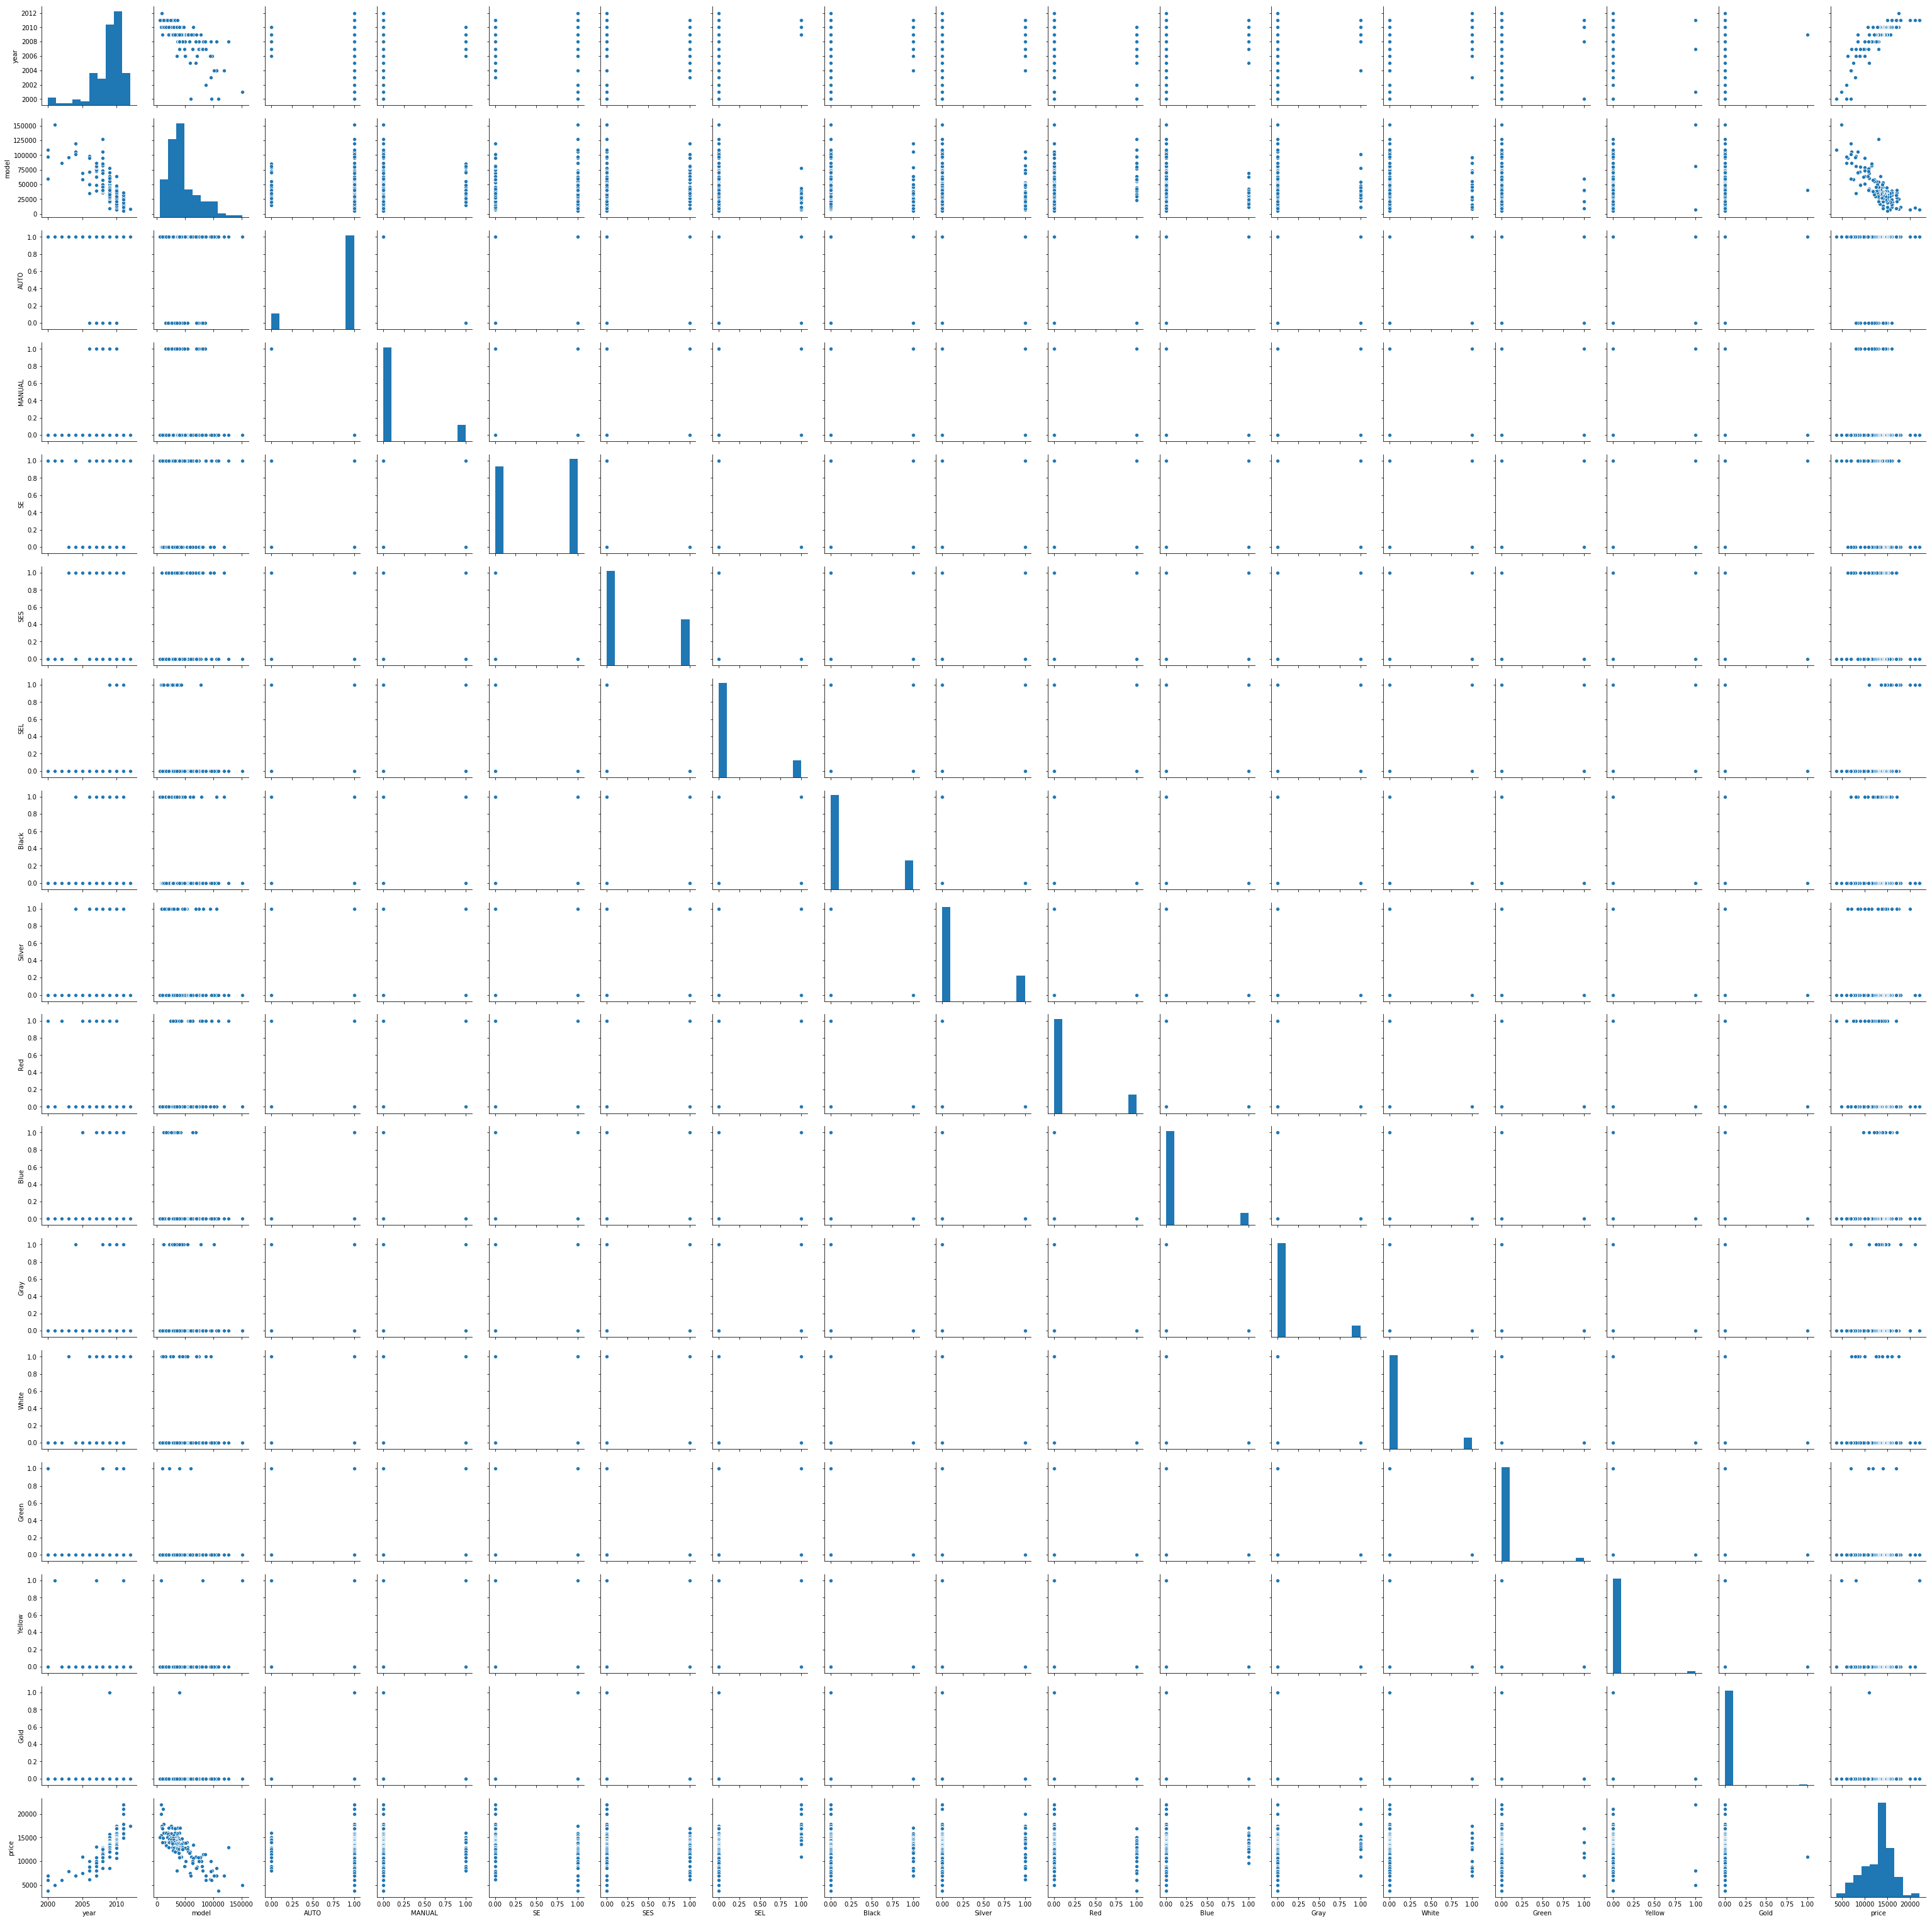

In [18]:
sns.pairplot(df)
plt.show()

In [19]:
# have to remember that the 'post-cast-to-float' arrays won't have headers
norm_num_features = norm_dataset(no_scale_pivoted_dataset_array, 2)
std_num_features = standardize_dataset(no_scale_pivoted_dataset_array, 2)

In [20]:
norm_num_features[:5]

array([[9.16666667e-01, 1.73655635e-02, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        2.19920000e+04],
       [9.16666667e-01, 4.13267672e-02, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.09950000e+04],
       [9.16666667e-01, 1.69426786e-02, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.99950000e+04],
       [9.16666667e-01, 4.60126047e-02, 1.00000000e+00, 0.000

In [21]:
std_num_features[:5]

array([[ 1.03634013e+00, -1.37020780e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  2.19920000e+04],
       [ 1.03634013e+00, -1.23957422e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  2.09950000e+04],
       [ 1.03634013e+00, -1.37251331e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.9

#### Putting the data back together as non-header, numerical feature data in three sets

Worth plotting some of the data at this point as well

**Key attributes:**

1. The column order is always consistent
    * model_year
    * mileage
    * transmissions (AUTO, MANUAL)
    * model_type (SE, SES, SEL)
    * colors (in consistent order) 
2. The 'objective' (price) is in the final column
3. No headers in the dataset (numpy needs consistent types in array)
4. Will have three versions of the same data
    

## 3. split the dataset into training, validation, and test populations

I will use the kwarg I put into the `split_dataset` that let's me pass in an external index array to split all three datasets the same way and compare performance apples-to-apples.

There are a couple of things I could poke at: feature selection, feature scaling.

i.e. Should I use all the features to predict or a subset? and How should I scale?

Downstream thing would be to figure out "Do I take an unweighted average of the k neighbors' prices?" or "Do I create a parameter (or vector space) by which I weight distances from my neighbors in my prices?"

For the "training/validation/test" split I'll use `90:30:30` in this exercise.

In [22]:
split_array1 = np.concatenate((np.ones(90), np.zeros(60)), 0)
np.random.shuffle(split_array1)

In [23]:
split_array2 = np.concatenate((np.ones(30), np.zeros(30)), 0)
np.random.shuffle(split_array2)

In [24]:
split_array1[:5]

array([0., 0., 0., 1., 0.])

In [25]:
training_no_scale, test_val_no_scale = split_dataset(no_scale_pivoted_dataset_array, 90, split_array=split_array1)

In [26]:
val_no_scale, test_no_scale = split_dataset(test_val_no_scale, 30, split_array=split_array2)

In [27]:
print training_no_scale.shape
print val_no_scale.shape
print test_no_scale.shape

(90, 17)
(30, 17)
(30, 17)


In [28]:
no_scale_val_predictions_average = predict_knn_regression_for_set(
    val_no_scale,
    training_no_scale,
    4,
    16
)

In [29]:
val_truth = [row[16] for row in val_no_scale]

In [30]:
val_truth[:5]

[21992.0, 19995.0, 17500.0, 16995.0, 16995.0]

In [31]:
no_scale_val_predictions_average[:5]

[16108.25, 16108.25, 16812.5, 14483.25, 13696.0]

In [32]:
no_scale_val_average_error = euclidean_distance(no_scale_val_predictions_average, val_truth, 30)

In [33]:
no_scale_val_average_error

13203.879361289999

In [34]:
no_scale_val_predictions_linear = predict_knn_regression_for_set(
    val_no_scale,
    training_no_scale,
    4,
    16,
    algorithm=predict_from_knn_linear_distance_weighted
)

In [36]:
no_scale_val_predictions_linear[:5]

[16099.623380415691,
 16092.997592528607,
 16650.667935892216,
 14103.678917072348,
 13503.358964433839]

In [37]:
no_scale_val_linear_error = euclidean_distance(no_scale_val_predictions_linear, val_truth, 30)

In [38]:
no_scale_val_linear_error

13461.062416548732

In [39]:
no_scale_val_predictions_gaussian = predict_knn_regression_for_set(
    val_no_scale,
    training_no_scale,
    4,
    16,
    algorithm=predict_from_knn_gaussian_distance_weighted
)

ZeroDivisionError: float division by zero

In [ ]:
# I think that the distances are too big and it is approximating the gaussian as zero

In [40]:
training_norm, test_val_norm = split_dataset(norm_num_features, 90, split_array=split_array1)
val_norm, test_norm = split_dataset(test_val_norm, 30, split_array=split_array2)

In [41]:
norm_val_predictions_average = predict_knn_regression_for_set(
    val_norm,
    training_norm,
    4,
    16
)

In [42]:
norm_val_predictions_average_error = euclidean_distance(norm_val_predictions_average, val_truth, 30)

In [43]:
norm_val_predictions_average_error

16701.123072266728

In [44]:
norm_val_predictions_linear = predict_knn_regression_for_set(
    val_norm,
    training_norm,
    4,
    16,
    algorithm=predict_from_knn_linear_distance_weighted
)

In [45]:
norm_val_predictions_linear_error = euclidean_distance(norm_val_predictions_linear, val_truth, 30)

In [46]:
norm_val_predictions_linear_error

16028.319634914078

In [48]:
norm_val_predictions_guassian = predict_knn_regression_for_set(
    val_norm,
    training_norm,
    4,
    16,
    algorithm=predict_from_knn_gaussian_distance_weighted
)

In [49]:
norm_val_predictions_guassian_error = euclidean_distance(norm_val_predictions_guassian, val_truth, 30)

In [50]:
norm_val_predictions_guassian_error

16485.035691074565

In [47]:
training_std, test_val_std = split_dataset(std_num_features, 90, split_array=split_array1)
val_std, test_std = split_dataset(test_val_std, 30, split_array=split_array2)

In [51]:
std_val_predictions_average = predict_knn_regression_for_set(
    val_std,
    training_std,
    4,
    16
)

In [52]:
std_val_predictions_average_error = euclidean_distance(std_val_predictions_average, val_truth, 30)

In [53]:
std_val_predictions_average_error

11907.854117661167

In [54]:
std_val_predictions_linear = predict_knn_regression_for_set(
    val_std,
    training_std,
    4,
    16,
    algorithm=predict_from_knn_linear_distance_weighted
)

In [55]:
std_val_predictions_linear_error = euclidean_distance(std_val_predictions_linear, val_truth, 30)

In [56]:
std_val_predictions_linear_error

11821.273709966354

In [57]:
std_val_predictions_gaussian = predict_knn_regression_for_set(
    val_std,
    training_std,
    4,
    16,
    algorithm=predict_from_knn_gaussian_distance_weighted
)

In [58]:
std_val_predictions_gaussian_error = euclidean_distance(std_val_predictions_gaussian, val_truth, 30)

In [59]:
std_val_predictions_gaussian_error

11641.002598704545

Let's predict the 4-NN for the first element in the test set

## 4. choose parameters to reduce and run predict_category_from_knn on validation set to minimize errors

Will add feature scaling to groups of features and look at a grid search along the scaling parameters.

#### now we are in business

Let's start from the standardized datasets with the gaussian distance weigths and use order of magnitude scaling search to see if there is are feature weighting parameters that can further minimize error. Will group transmission, model, and color scaling, so there will be 5 x 3 = 15 iterations.

In [60]:
search_param = np.array([10, 1, 0.1])

In [61]:
apply_list = [np.ones(1), np.ones(1), np.ones(2), np.ones(3), np.ones(9)]

In [65]:
apply_arrays = []
for item in search_param:
    array_row = [item * array for array in apply_list]
    apply_arrays.append(array_row)
    

In [66]:
apply_arrays[:2]

[[array([10.]),
  array([10.]),
  array([10., 10.]),
  array([10., 10., 10.]),
  array([10., 10., 10., 10., 10., 10., 10., 10., 10.])],
 [array([1.]),
  array([1.]),
  array([1., 1.]),
  array([1., 1., 1.]),
  array([1., 1., 1., 1., 1., 1., 1., 1., 1.])]]

In [68]:
len(apply_arrays)

3

In [69]:
thing = []
for i in range(3):
    row = []
    for j in range(5):
        row.append(apply_arrays[i][j])
    thing.append(row)

In [70]:
len(thing)

3

In [71]:
len(thing[1])

5

## 5. find score for algorithm

I've got all the different scaled datasets split similarly I can look at the effect on the score of the different feature scalings and of cutting out some of the categorical values.

## Conclusion?

